This script takes the downloaded data from sports-reference.com and parses through to get the teams and scores for all regular season games.  It then interprets and analyzes the data, creating visualizations.

In [4]:
#Import all relevant packages
from bs4 import BeautifulSoup as bs
import datetime
import matplotlib.pyplot as plt
import numpy as np

In [5]:
#set dates for the parser to analyze so that all regular season games in the 2018-2019 season are considered
currentDate = datetime.date(2018, 11, 6)
endDate = datetime.date(2019, 3, 18)
delta = datetime.timedelta(days=1)

#setting up a way to record data in an organized way
gameList = []
index = 0

while currentDate<=endDate:
    
    filein = f'DAYS{currentDate}.html'
    soup = bs(open(filein), 'lxml')
    #separate all entries out into individual games and from games into individual team components
    games = soup.find_all('tbody')
    

    #gathering and adding data to the list in the format gameList[game number][team (0 for home 1 for away)][score]
    for game in games:
        gameList.append([])
        
        teams = game.find_all('td')
        
        gameList[index].append([])
        team1 = teams[0].get_text()
        team1Name = ''.join(x for x in team1 if  x.isalpha())
        team1Rank = ''.join(x for x in team1 if  x.isdecimal())
        team1Score = teams[1].get_text()
        gameList[index][0].append(team1Name)
        gameList[index][0].append(int(team1Score))
        
        #All data for team 2
        gameList[index].append([])
        team2 = teams[3].get_text()
        team2Name = ''.join(x for x in team2 if  x.isalpha())
        team2Score = teams[4].get_text()
        team2Rank = ''.join(x for x in team2 if  x.isdecimal())
        gameList[index][1].append(team2Name)
        gameList[index][1].append(int(team2Score))
        
        
        index+=1
        
    currentDate+=delta

In [6]:
#Record stats for all teams.  The data for each team is held in a dictionary 
#This subdictionary will record 'Teams beaten', 'Teams lost to', 'Away games', 'Home games', 'Wins', 'Losses', 'Points for', and 'Points against'

teams = {}
for game in gameList:
    #Creating entry and subdictionary for each away team if it does not already exist
    if game[0][0] not in teams:
        teams[game[0][0]] = {}
        teams[game[0][0]]['Teams beaten'] = []
        teams[game[0][0]]['Teams lost to'] = []
        teams[game[0][0]]['Away games'] = 0
        teams[game[0][0]]['Home games'] = 0
        teams[game[0][0]]['Points for'] = 0
        teams[game[0][0]]['Points against'] = 0
        teams[game[0][0]]['Losses'] = 0 
        teams[game[0][0]]['Wins'] = 0
    
    #Editing the subdictionary entries for each away team
    if game[0][1]>game[1][1]:
        teams[game[0][0]]['Teams beaten'].append(game[1][0])
        teams[game[0][0]]['Wins'] += 1
    else:
        teams[game[0][0]]['Teams lost to'].append(game[1][0])
        teams[game[0][0]]['Losses'] += 1
        
    teams[game[0][0]]['Points for'] += game[0][1]
    teams[game[0][0]]['Points against'] += game[1][1]
    teams[game[0][0]]['Away games']+=1
    
    #Creating entry and subdictionary for each home team if it does not already exist
    if game[1][0] not in teams:
        teams[game[1][0]] = {}
        teams[game[1][0]]['Teams beaten'] = []
        teams[game[1][0]]['Teams lost to'] = []
        teams[game[1][0]]['Home games'] = 0
        teams[game[1][0]]['Away games'] = 0
        teams[game[1][0]]['Points for'] = 0
        teams[game[1][0]]['Points against'] = 0
        teams[game[1][0]]['Losses'] = 0 
        teams[game[1][0]]['Wins'] = 0
    
        
    #Editing the subdictionary entries for each home team
    if game[1][1]>game[0][1]:
        teams[game[1][0]]['Teams beaten'].append(game[0][0])
        teams[game[1][0]]['Wins'] += 1
    else:
        teams[game[1][0]]['Teams lost to'].append(game[0][0])
        teams[game[1][0]]['Losses'] += 1
    
    teams[game[1][0]]['Points for']+=game[1][1]
    teams[game[1][0]]['Points against']+=game[0][1]
    teams[game[1][0]]['Home games'] += 1
    
        
        

In [7]:
# Making arrays of points for and against
pts_for = []
pts_against=[]
for team in teams:
    if teams[team]['Points for'] > 1000:
        pts_for.append(teams[team]['Points for'])
        pts_against.append(teams[team]['Points against'])

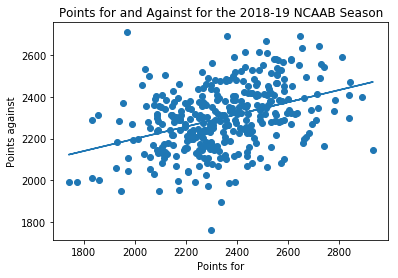

In [8]:
#Make a scatterplot with points for and against
pts_for = np.array(pts_for)
pts_against=np.array(pts_against)
    
plt.scatter(pts_for, pts_against)
plt.xlabel('Points for')
plt.ylabel('Points against')
plt.title('Points for and Against for the 2018-19 NCAAB Season')


#Create linear regression line for this scatterplot
m, b = np.polyfit(pts_for, pts_against, 1)
plt.plot(pts_for, m*pts_for+b)

This plot shows that there is a mildly positive correlation between the points a team scores and how many points its opponents score over a season.  I was looking to measure something like pace of play in this plot, so I was surprised the correlation was not stronger.  Still, there is a general direction with the difference in quality of the teams explaining the relatively loose fit of the regression.

In [9]:
#Create arrays with point differentials and wins for each team
pt_dif = []
wins = []

for team in teams:
    if teams[team]['Points for'] > 1000:
        pt_dif.append(teams[team]['Points for']-teams[team]['Points against'])
        wins.append(teams[team]['Wins'])

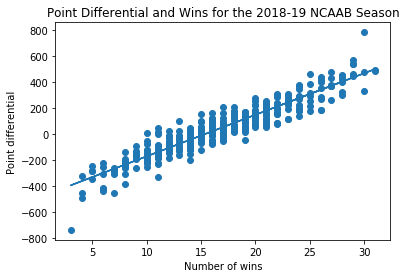

In [10]:
#Compare point differential against number of wins in a scatterplot
pt_dif = np.array(pt_dif)
wins = np.array(wins)

plt.scatter(wins, pt_dif)
plt.xlabel('Number of wins')
plt.ylabel('Point differential')
plt.title('Point Differential and Wins for the 2018-19 NCAAB Season')

#Create linear regression line for this plot 
m, b = np.polyfit(wins, pt_dif, 1)
plt.plot(wins, m*wins+b)

This plot shows that there is a strong correlation between margin of victory and the number of wins a team is likely to win in a season.  This makes sense, since a team that wins a lot will have a largely positive point differential and the opposite is also true.  Even though I suspected this would be the case, it still surprised me how tight the fit was to the regression line.  Perhaps in the future, I will look into the degree to which previous point differential affects the likelihood of winning future games.

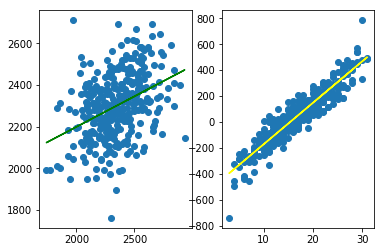

In [11]:
#Create a two panel figure with these two plots

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.scatter(pts_for, pts_against)
m, b = np.polyfit(pts_for, pts_against, 1)
ax1.plot(pts_for, m*pts_for+b, color = 'green')

ax2.scatter(wins, pt_dif)
m, b = np.polyfit(wins, pt_dif, 1)
ax2.plot(wins, m*wins+b, color = 'yellow')

# Homework P3

In [12]:
import networkx as nx
import pandas as pd

In [13]:
#Make base graph with teams as nodes
G= nx.DiGraph()
G.add_nodes_from(teams)

In [14]:
#Add relevant edges to the graph for teams who played each other
for team in teams:
    weight = 0
    for beaten in teams[team]['Teams beaten']:
        weight += ((teams[beaten]['Wins']**3)/teams[beaten]['Losses']) * (teams[beaten]['Points for']/teams[beaten]['Points against'])
    teams[team]['Cumulative weight'] = weight

for node in G:
    for team in teams[node]['Teams beaten']:
        G.add_edge(team, node, weight = teams[team]['Cumulative weight'])
      

In [15]:
#Use graph with weights to create PageRank score for each team
pr = nx.pagerank(G)

/usr/lib/python3/dist-packages/networkx/generators/stochastic.py:56: UserWarning: zero out-degree for node LenoirRhyne
  warnings.warn('zero out-degree for node %s' % u)
/usr/lib/python3/dist-packages/networkx/generators/stochastic.py:56: UserWarning: zero out-degree for node AlaskaAnchorage
  warnings.warn('zero out-degree for node %s' % u)
/usr/lib/python3/dist-packages/networkx/generators/stochastic.py:56: UserWarning: zero out-degree for node AngeloState
  warnings.warn('zero out-degree for node %s' % u)
/usr/lib/python3/dist-packages/networkx/generators/stochastic.py:56: UserWarning: zero out-degree for node ArlingtonBaptist
  warnings.warn('zero out-degree for node %s' % u)
/usr/lib/python3/dist-packages/networkx/generators/stochastic.py:56: UserWarning: zero out-degree for node BemidjiState
  warnings.warn('zero out-degree for node %s' % u)
/usr/lib/python3/dist-packages/networkx/generators/stochastic.py:56: UserWarning: zero out-degree for node BobJonesUniversity
  warnings.war

In [16]:
#add Pagerank score to teams data
for node in pr:
    teams[node]['Pagerank score'] = pr[node]

In [17]:
#Convert teams data to DataFrame and sort by Pagerank Score
teams_df = pd.DataFrame(teams).T
teams_df = teams_df.sort_values(by='Pagerank score', ascending = False)

In [18]:
#Make dataframe for gameList Data

homeTeam = []
awayTeam = []
homeTeamScore = []
awayTeamScore = []
winner = []
homeMargin = []
awayMargin = []

for game in gameList:
    awayTeam.append(game[0][0])
    homeTeam.append(game[1][0])
    awayTeamScore.append(game[0][1])
    homeTeamScore.append(game[1][1])
    winner.append(game[0][0] if game[0][1]>game[1][1] else game[1][0])
    awayMargin.append(game[0][1]-game[1][1])
    homeMargin.append(game[1][1]-game[0][1])

    
    
game_data = {'Home team': homeTeam, 'Away team': awayTeam, 'Winner': winner, 'Home score': homeTeamScore, 'Away score': awayTeamScore, 'Home margin': homeMargin, 'Away margin': awayMargin}

game_df = pd.DataFrame(game_data)


In [19]:
#Add PageRank scores to data 
homePR = []
awayPR = []

for team in game_df['Home team']:
    homePR.append(teams_df['Pagerank score'][team])

for team in game_df['Away team']:
    awayPR.append(teams_df['Pagerank score'][team])

game_df['Home PR'] = homePR
game_df['Away PR'] = awayPR

In [20]:
#Adding primary key to access games more effectively
game_id = range(len(game_df))
game_df['Game ID'] = game_id

In [21]:
#Adding more Pagerank score related data to the table

home_pr_diff = []
away_pr_diff = []
pr_guess = []

for game in game_df['Game ID']:
    pr_guess.append(game_df['Home team'][game] if game_df['Home PR'][game] > game_df['Away PR'][game] else game_df['Away team'][game])
    home_pr_diff.append(game_df['Home PR'][game] - game_df['Away PR'][game])
    away_pr_diff.append(game_df['Away PR'][game] - game_df['Home PR'][game])

game_df['PR Guess'] = pr_guess
game_df['Away PR difference'] = away_pr_diff
game_df['Home PR difference'] = home_pr_diff

In [22]:
#Add binary column for showing if PR guess is correct
pr_correct = []

for game in game_df['Game ID']:
    if game_df['Winner'][game] == game_df['PR Guess'][game]:
        pr_correct.append(1)
    else:
        pr_correct.append(0)

game_df['PR correct'] = pr_correct

In [23]:
# Shows the accuracy rate of the PageRank-based sytem at predicting game winners
game_df['PR correct'].mean()

0.75211505922165822

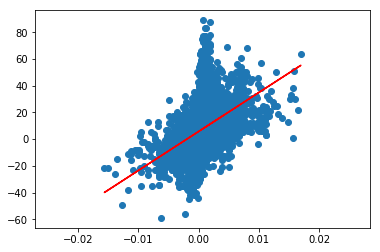

In [24]:
#Create scatter plot with regression line be

plt.scatter(game_df['Home PR difference'], game_df['Home margin'])
m, b = np.polyfit(game_df['Home PR difference'], game_df['Home margin'], 1)
plt.plot(game_df['Home PR difference'], m*game_df['Home PR difference']+b, 'r')

<function matplotlib.pyplot.show(*args, **kw)>

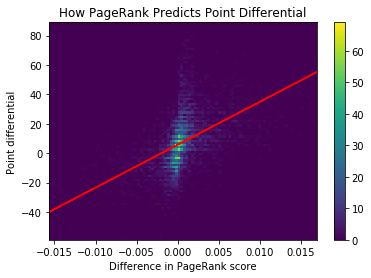

In [25]:
#Create histogram with heatmap of the same data

plt.hist2d(game_df['Home PR difference'], game_df['Home margin'], bins=100, normed=False)
plt.colorbar()
plt.ylabel('Point differential')
plt.xlabel('Difference in PageRank score')
plt.title('How PageRank Predicts Point Differential')
m, b = np.polyfit(game_df['Home PR difference'], game_df['Home margin'], 1)
plt.plot(game_df['Home PR difference'], m*game_df['Home PR difference']+b, 'r')
plt.show

### Interpretation
This plot shows that the PageRank-based ranking system predicts the point differential fairly well in a linear regression, but as the heat map histogram shows, there is a high distribution of games where the point differential is small and an even higher ditribution of games where the PageRank score is very close.  As such, I will need to adjust the model by adding degrees/knots and modifying the weight for determining the score. Hopefully doing so will yield a more predictive model.

<function matplotlib.pyplot.show(*args, **kw)>

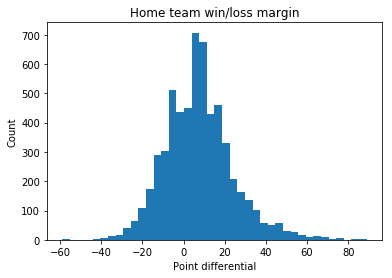

In [43]:
plt.hist(game_df['Home margin'], bins = 40)
plt.title('Home team win/loss margin')
plt.xlabel('Point differential')
plt.ylabel('Count')
plt.show

### Interpretation
This shows that the margin of victory/defeat for home teams follows a roughly normal distribution with the mean located somewhere between 1 and 10.  Importantly, this means that home teams are more likely to win than away teams in the data and most scores are relatively close, meaning within a 10 point margin.

In [36]:
game_df

,Away margin,Away score,Away team,Home margin,Home score,Home team,Winner,Home PR,Away PR,Game ID,PR Guess,Away PR difference,Home PR difference,PR correct
0,-5,87,MichiganState,5,92,Kansas,Kansas,0.013002,0.008797,0,Kansas,-0.004205,0.004205,1
1,34,118,Duke,-34,84,Kentucky,Duke,0.011088,0.017574,1,Duke,0.006486,-0.006486,1
2,-41,79,IdahoState,41,120,Gonzaga,Gonzaga,0.007781,0.000976,2,Gonzaga,-0.006805,0.006805,1
3,-31,42,Towson,31,73,Virginia,Virginia,0.010924,0.001224,3,Virginia,-0.009700,0.009700,1
4,-45,41,LenoirRhyne,45,86,Tennessee,Tennessee,0.009309,0.000374,4,Tennessee,-0.008935,0.008935,1
5,-16,70,BYU,16,86,Nevada,Nevada,0.004460,0.002932,5,Nevada,-0.001528,0.001528,1
6,11,78,UNC,-11,67,Wofford,UNC,0.002347,0.013627,6,UNC,0.011280,-0.011280,1
7,-23,77,MorganState,23,100,Villanova,Villanova,0.007715,0.000729,7,Villanova,-0.006986,0.006986,1
8,-43,58,SouthAlabama,43,101,Auburn,Auburn,0.006956,0.001334,8,Auburn,-0.005623,0.005623,1
9,-27,57,PortlandState,27,84,Oregon,Oregon,0.003492,0.001519,9,Oregon,-0.001973,0.001973,1
